In [1]:
%matplotlib inline
from typing import Type
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor
from torch.optim import SGD
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import pandas as pd

## Get the data

In [2]:
# fetch dataset 
# https://archive.ics.uci.edu/dataset/186/wine+quality
data = fetch_ucirepo(name='wine quality')

In [3]:
data.variables

,name,role,type,demographic,description,units,missing_values
0,fixed_acidity,Feature,Continuous,None,None,None,no
1,volatile_acidity,Feature,Continuous,None,None,None,no
2,citric_acid,Feature,Continuous,None,None,None,no
3,residual_sugar,Feature,Continuous,None,None,None,no
4,chlorides,Feature,Continuous,None,None,None,no
5,free_sulfur_dioxide,Feature,Continuous,None,None,None,no
6,total_sulfur_dioxide,Feature,Continuous,None,None,None,no
7,density,Feature,Continuous,None,None,None,no
8,pH,Feature,Continuous,None,None,None,no
9,sulphates,Feature,Continuous,None,None,None,no


In [4]:
data.data.features.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [5]:
data.data.targets.head()

,quality
0,5
1,5
2,5
3,6
4,5


<Axes: xlabel='quality', ylabel='count'>

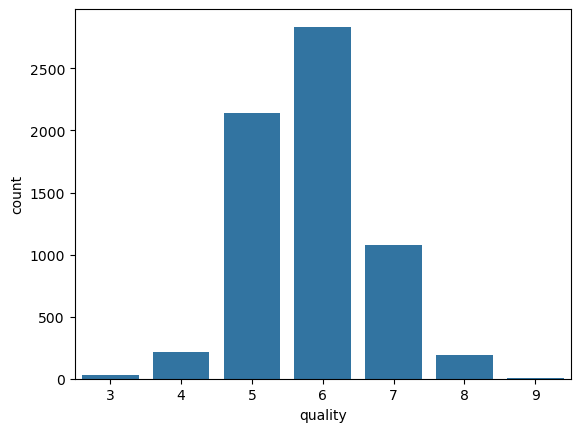

In [6]:
fig, ax = plt.subplots()
sns.countplot(data=data.data.targets, x='quality', ax=ax)

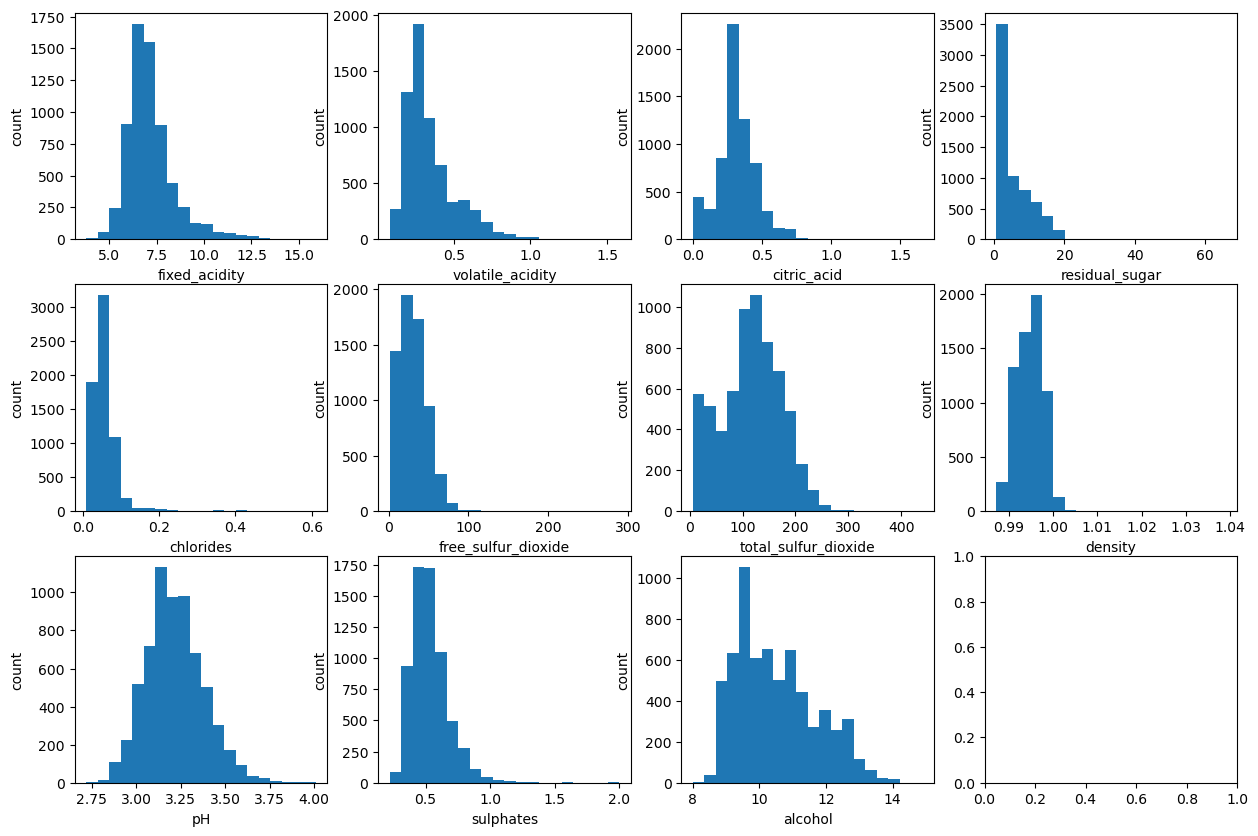

In [7]:
fig, axarr = plt.subplots(figsize=(15, 10), ncols=4, nrows=3)

for ax, column in zip(axarr.ravel(), data.data.features.columns):
    ax.hist(data.data.features[column], bins=20)
    ax.set_xlabel(column)
    ax.set_ylabel('count')

# Convert data to torch.Tensor

In [8]:
x = data.data.features.to_numpy(dtype=np.float32)
x = torch.from_numpy(x)

In [9]:
y = data.data.targets.to_numpy(dtype=np.float32)
y = torch.from_numpy(y)

## Split the dataset

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

In [11]:
len(x_train), len(x_val), len(x_test)

(4157, 1040, 1300)

## Preprocessing

### Apply standardisation to inputs

In [12]:
x_mean = x_train.mean(dim=0)
x_std = x_train.std(dim=0)
for name, mean, std in zip(data.data.features.columns, x_mean, x_std):
    print(f'{name: >20s}: {mean=: >7.3f}, {std=: >6.3f}')

       fixed_acidity: mean=  7.227, std= 1.301
    volatile_acidity: mean=  0.339, std= 0.165
         citric_acid: mean=  0.321, std= 0.147
      residual_sugar: mean=  5.428, std= 4.785
           chlorides: mean=  0.056, std= 0.034
 free_sulfur_dioxide: mean= 30.307, std=17.587
total_sulfur_dioxide: mean=114.848, std=56.609
             density: mean=  0.995, std= 0.003
                  pH: mean=  3.218, std= 0.162
           sulphates: mean=  0.532, std= 0.145
             alcohol: mean= 10.491, std= 1.183


In [13]:
x_train = (x_train - x_mean) / x_std
x_val = (x_val - x_mean) / x_std
x_test = (x_test - x_mean) / x_std

### Apply min-max scaling to targets

In [14]:
y_min = y.min(dim=0).values
y_max = y.max(dim=0).values
y_range = (y_max - y_min)

In [15]:
y_train = (y_train - y_min) / y_range
y_val = (y_val - y_min) / y_range
y_test = (y_test - y_min) / y_range

## Dataset

In [16]:
train_set = TensorDataset(x_train, y_train)
val_set = TensorDataset(x_val, y_val)
test_set = TensorDataset(x_test, y_test)

# Model

In [17]:
class MultiLayerPerceptron(nn.Module):

    def __init__(self,
                 input_dim: int,
                 output_dim: int,
    ):
        """
        """
        super().__init__()

        hidden_dim_0 = 64
        hidden_dim_1 = 64
        
        # 1st hidden layer
        ## affine transformation
        self.linear_0 = nn.Linear(input_dim, hidden_dim_0, bias=True)
        ## activation
        self.act_0 = nn.ReLU()

        # 2nd hidden layer
        ## affine transformation
        self.linear_1 = nn.Linear(hidden_dim_0, hidden_dim_1, bias=True)
        ## activation
        self.act_1 = nn.ReLU()

        # output layer
        ## affine transformation
        self.linear_2 = nn.Linear(hidden_dim_1, output_dim, bias=True)


    def forward(self, input: Tensor) -> Tensor:
        """
        Args:
            input: a flaot32 Tensor
        Returns:
            output: a float32 Tensor
        Shape:
            input: (N, D_in), where N denotes batch size and D_in denotes `input_dim`
            output: (N, D_out), where D_out denotes `output_dim`
        """
        # alias 
        x = input
        
        h = self.linear_0(x)
        h = self.act_0(h)
        h = self.linear_1(h)
        h = self.act_1(h)
        h = self.linear_2(h)
        return h

In [18]:
# or we can use a simpler API
model = nn.Sequential(
    nn.Linear(11, 64, bias=True),
    nn.ReLU(),
    nn.Linear(64, 64, bias=True),
    nn.ReLU(),
    nn.Linear(64, 1, bias=True)
)

In [19]:
model

Sequential(
  (0): Linear(in_features=11, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=1, bias=True)
)

In [20]:
for name, parameter in model.named_parameters():
    shape = tuple(parameter.shape)
    print(f'{name: >20s}: {shape=}, {parameter.dtype}, {parameter.device}')

num_parameters = sum(each.numel() for each in model.parameters())
print(f'{num_parameters=:_d}')

            0.weight: shape=(64, 11), torch.float32, cpu
              0.bias: shape=(64,), torch.float32, cpu
            2.weight: shape=(64, 64), torch.float32, cpu
              2.bias: shape=(64,), torch.float32, cpu
            4.weight: shape=(1, 64), torch.float32, cpu
              4.bias: shape=(1,), torch.float32, cpu
num_parameters=4_993


# Use GPUs!

In [21]:
!nvidia-smi

Wed Sep 25 16:30:50 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.28.03              Driver Version: 560.28.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           Off |   00000000:0B:00.0 Off |                    0 |
| N/A   37C    P0             43W /  300W |       1MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [22]:
device = torch.device('cuda:0')

In [23]:
model = model.to(device)

- [Mean squared error loss function](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)
- The choice of a loss function is also one of hyperparameters

In [24]:
criterion = nn.MSELoss().to(device)

In [25]:
optimizer = SGD(
    params=model.parameters(),
    lr=1e-3 # hyperparameters!hyperparameters!
)

In [26]:
train_loader = DataLoader(
    dataset=train_set,
    batch_size=64, # hyperparameters!
    shuffle=True, # to do "stochastic" gradient descent
    drop_last=True
)

val_loader = DataLoader(
    dataset=val_set,
    batch_size=64,
    shuffle=False,
    drop_last=False
)

In [28]:
min_val_loss = float('inf')
best_epoch = -1
best_checkpoint_path = './best.pt'

train_curve: list[dict[str, float]] = []
val_curve: list[dict[str, float]] = []

num_epochs = 100 # hyperparameters!

global_step = 0
for epoch in (pbar := tqdm.trange(num_epochs + 1)):
    if epoch >= 1:
        model.train()
        for x, y_true in train_loader:
            x, y_true = x.to(device), y_true.to(device)
        
            optimizer.zero_grad()
            y_score = model(x)
            loss = criterion(input=y_score, target=y_true) 
    
            # magic here
            loss.backward()
            optimizer.step()
    
            global_step += 1
            train_curve.append({
                'step': global_step,
                'loss': loss.item()
            })

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y_true in val_loader:
            x, y_true = x.to(device), y_true.to(device)
            y_score = model(x)
            loss = criterion(input=y_score, target=y_true)
            val_loss += loss.item()
        # divide 
    val_loss /= len(val_loader)
    
    val_curve.append({
        'step': global_step,
        'loss': val_loss,
    })

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        best_epoch = epoch

        
        torch.save(x, best_checkpoint_path)

    pbar.set_description(f'Epoch={epoch: >4d}: {min_val_loss=:.6f} @ {best_epoch=}')

Epoch= 100: min_val_loss=0.016850 @ best_epoch=100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:10<00:00,  9.41it/s]


In [29]:
train_curve = pd.DataFrame(train_curve)
val_curve = pd.DataFrame(val_curve)

Text(0, 0.5, 'MSELoss')

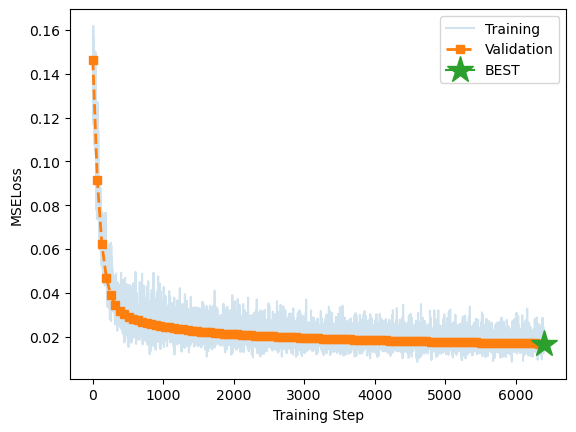

In [30]:
fig, ax = plt.subplots()
ax.plot(train_curve['step'], train_curve['loss'], label='Training', alpha=0.2)
ax.plot(val_curve['step'], val_curve['loss'], label='Validation', marker='s', ls='--', lw=2)

best_val_idx = val_curve['loss'].argmin()
ax.plot(val_curve['step'].iloc[best_val_idx], val_curve['loss'].iloc[best_val_idx], label='BEST', marker='*', markersize=20)
    
ax.legend()
ax.set_xlabel('Training Step')
ax.set_ylabel(criterion.__class__.__name__)

In [31]:
test_loader = DataLoader(
    dataset=test_set,
    batch_size=64,
    shuffle=False,
    drop_last=False
)

In [32]:
model.eval()

test_loss = 0
test_total = 0
test_correct = 0

with torch.no_grad():
    for x, y_true in test_loader:
        x, y_true = x.to(device), y_true.to(device)
        y_score = model(x)

        loss = criterion(input=y_score, target=y_true)
        test_loss += loss.item()

        # undo preprocessing and round
        y_pred = (y_score.cpu() * y_range + y_min).round().long()
        y_true = (y_true.cpu() * y_range + y_min).round().long()

        y_true = y_true.long()

        test_total += len(y_true)
        test_correct += y_pred.eq(y_true).sum().item()

        

test_loss /= len(test_loader)
test_acc = test_correct / test_total

print(f'{test_loss=:.2f}')
print(f'{100 * test_acc=:.2f}%')

test_loss=0.02
100 * test_acc=50.69%
